In [9]:
from sensor_network_utils import * 
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

In [10]:
# Load data
flowdata_paths = ['data/dailyflow_v3_1.csv', 'data/dailyflow_v3_2.csv']
df_cleaned, gauges_gdf, flowlines_gdf, usgs_index_df = load_data(
    flowdata_paths,
    'data/gage_12_shpaefile/SWIM_gage_loc_12.shp',
    'data/tx_gulf_flowlines/flowlines.shp',
    'data/gage_12.csv'
)

In [ ]:
# Preprocessing and K-Fold Setup
df_cleaned['Date'] = pd.to_datetime(df_cleaned.index)
df_cleaned['Year'] = df_cleaned['Date'].dt.year
years = df_cleaned['Year'].unique()

selected_sensors_by_year = {}
sensor_rankings_by_year = {}

for year in years:
    print(f'Processing year {year}...')
    train_data = df_cleaned[df_cleaned['Year'] != year].drop(['Date', 'Year'], axis=1)
    test_data = df_cleaned[df_cleaned['Year'] == year].drop(['Date', 'Year'], axis=1)

    X_train = train_data.values
    X_test = test_data.values

    n_sensor = 64907
    sensor_location = sensor_placement_qr(X_train, n_sensor)
    selected_sensors_by_year[year] = sensor_location

    sensor_rankings_by_year[year] = {
        sensor: rank for rank, sensor in enumerate(sensor_location, start=1)
    }

In [12]:
rankings_df = pd.DataFrame(sensor_rankings_by_year)
rankings_df['Mean Rank'] = rankings_df.mean(axis=1)
rankings_df['Median Rank'] = rankings_df.median(axis=1)
rankings_df['Standard Deviation'] = rankings_df.std(axis=1)

stats_df = pd.DataFrame({
    'name': rankings_df.index,
    'meanRank': rankings_df['Mean Rank'],
    'medianRank': rankings_df['Median Rank'],
    'q1': rankings_df.iloc[:, :-3].quantile(0.25, axis=1),
    'q3': rankings_df.iloc[:, :-3].quantile(0.75, axis=1),
    'min': rankings_df.iloc[:, :-3].min(axis=1),
    'max': rankings_df.iloc[:, :-3].max(axis=1),
    'variance': rankings_df.iloc[:, :-3].var(axis=1)
}).reset_index(drop=True)

stats_df_sorted = stats_df.sort_values('medianRank').reset_index(drop=True)

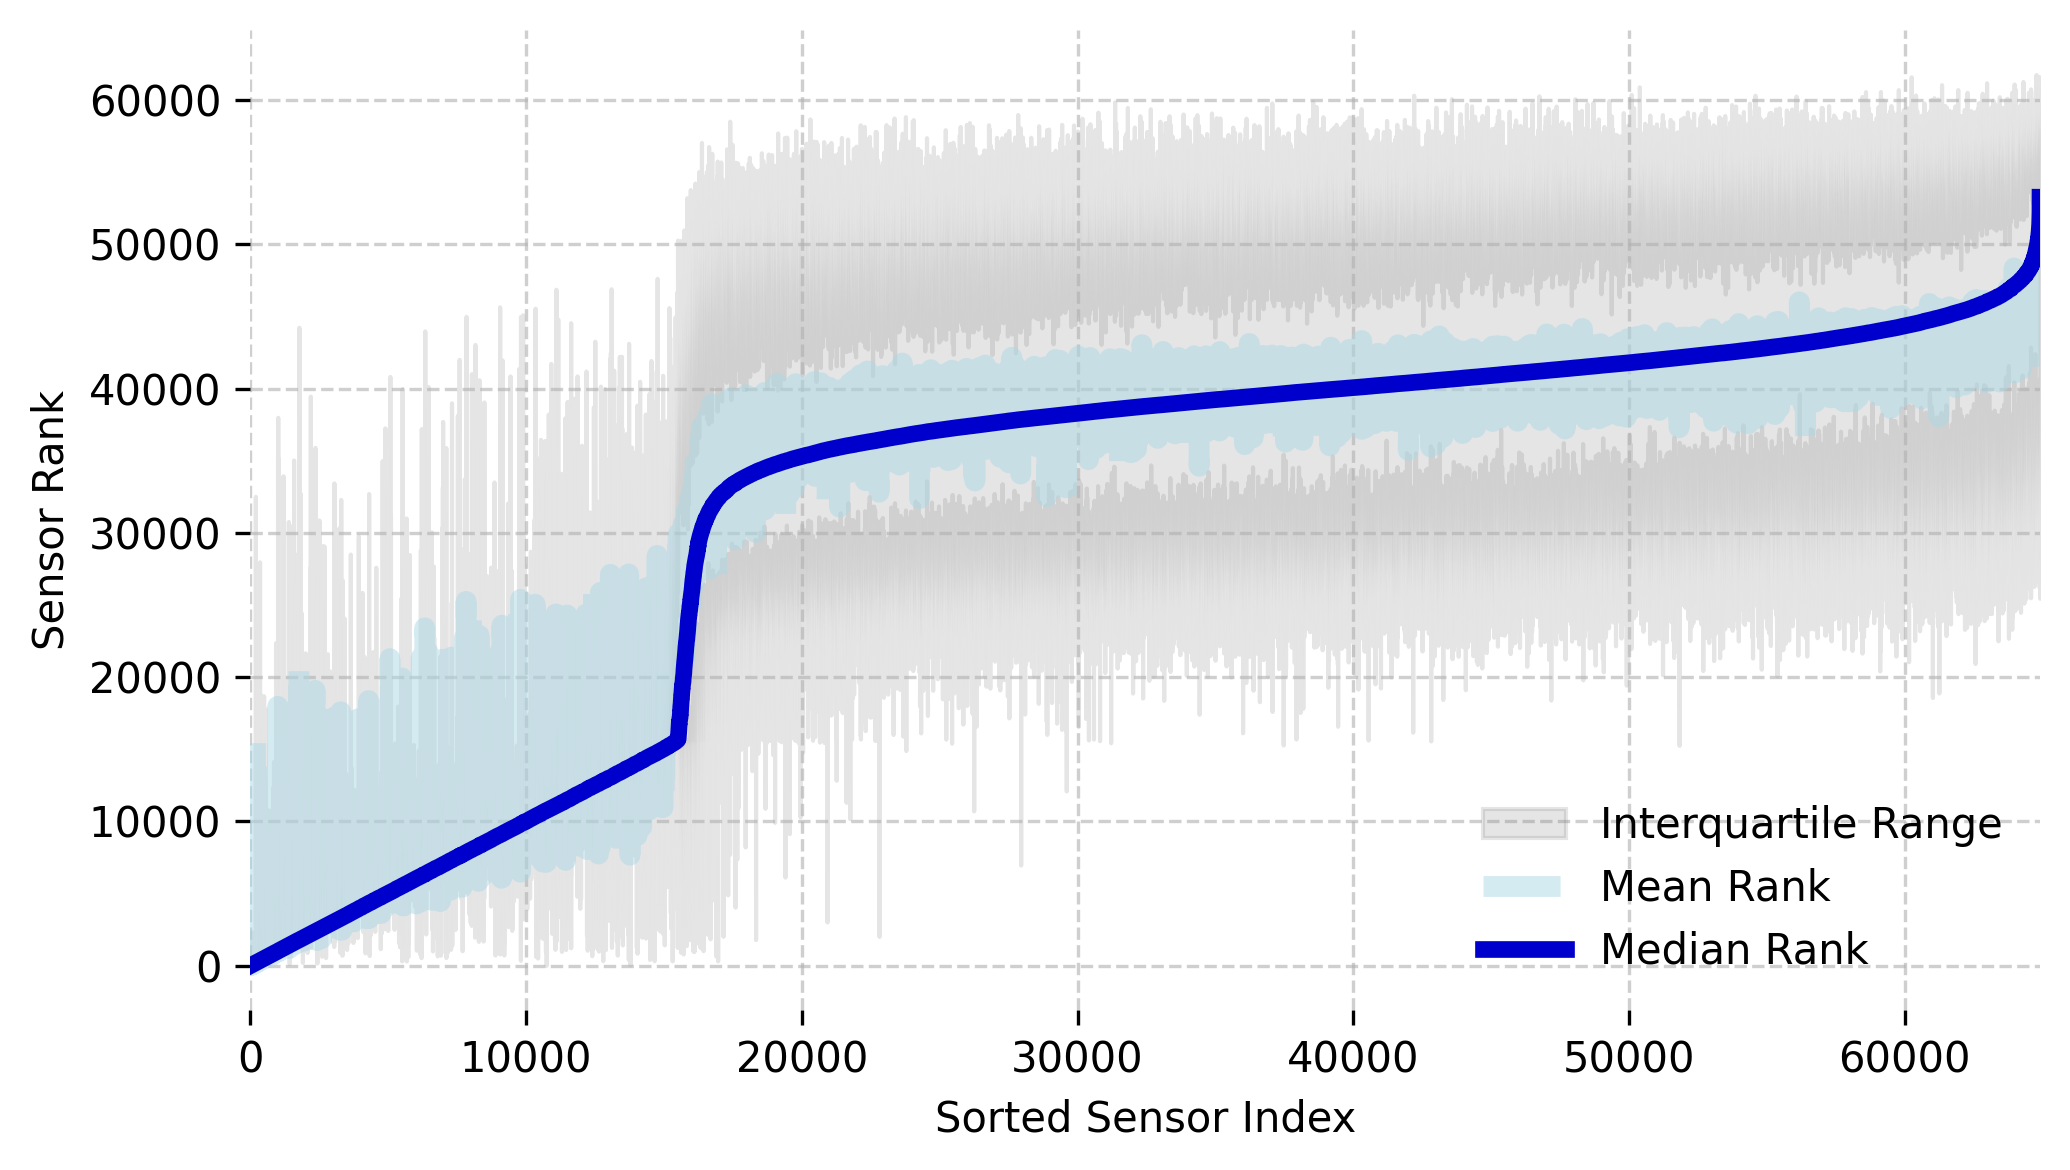

In [13]:
# Plotting Rankings
plt.figure(figsize=(7, 4), dpi=300)
plt.fill_between(
    stats_df_sorted.index,
    stats_df_sorted['q1'],
    stats_df_sorted['q3'],
    color='grey',
    alpha=0.2,
    label='Interquartile Range'
)
plt.plot(
    stats_df_sorted.index,
    stats_df_sorted['meanRank'],
    color='lightblue',
    linestyle='--',
    linewidth=5,
    alpha=0.5,
    label='Mean Rank'
)
plt.plot(
    stats_df_sorted.index,
    stats_df_sorted['medianRank'],
    color='mediumblue',
    linewidth=4,
    label='Median Rank'
)
plt.xlabel('Sorted Sensor Index')
plt.ylabel('Sensor Rank')
plt.legend(loc='lower right', frameon=False)
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.xlim([stats_df_sorted.index.min(), stats_df_sorted.index.max()])
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.tight_layout()
plt.show()

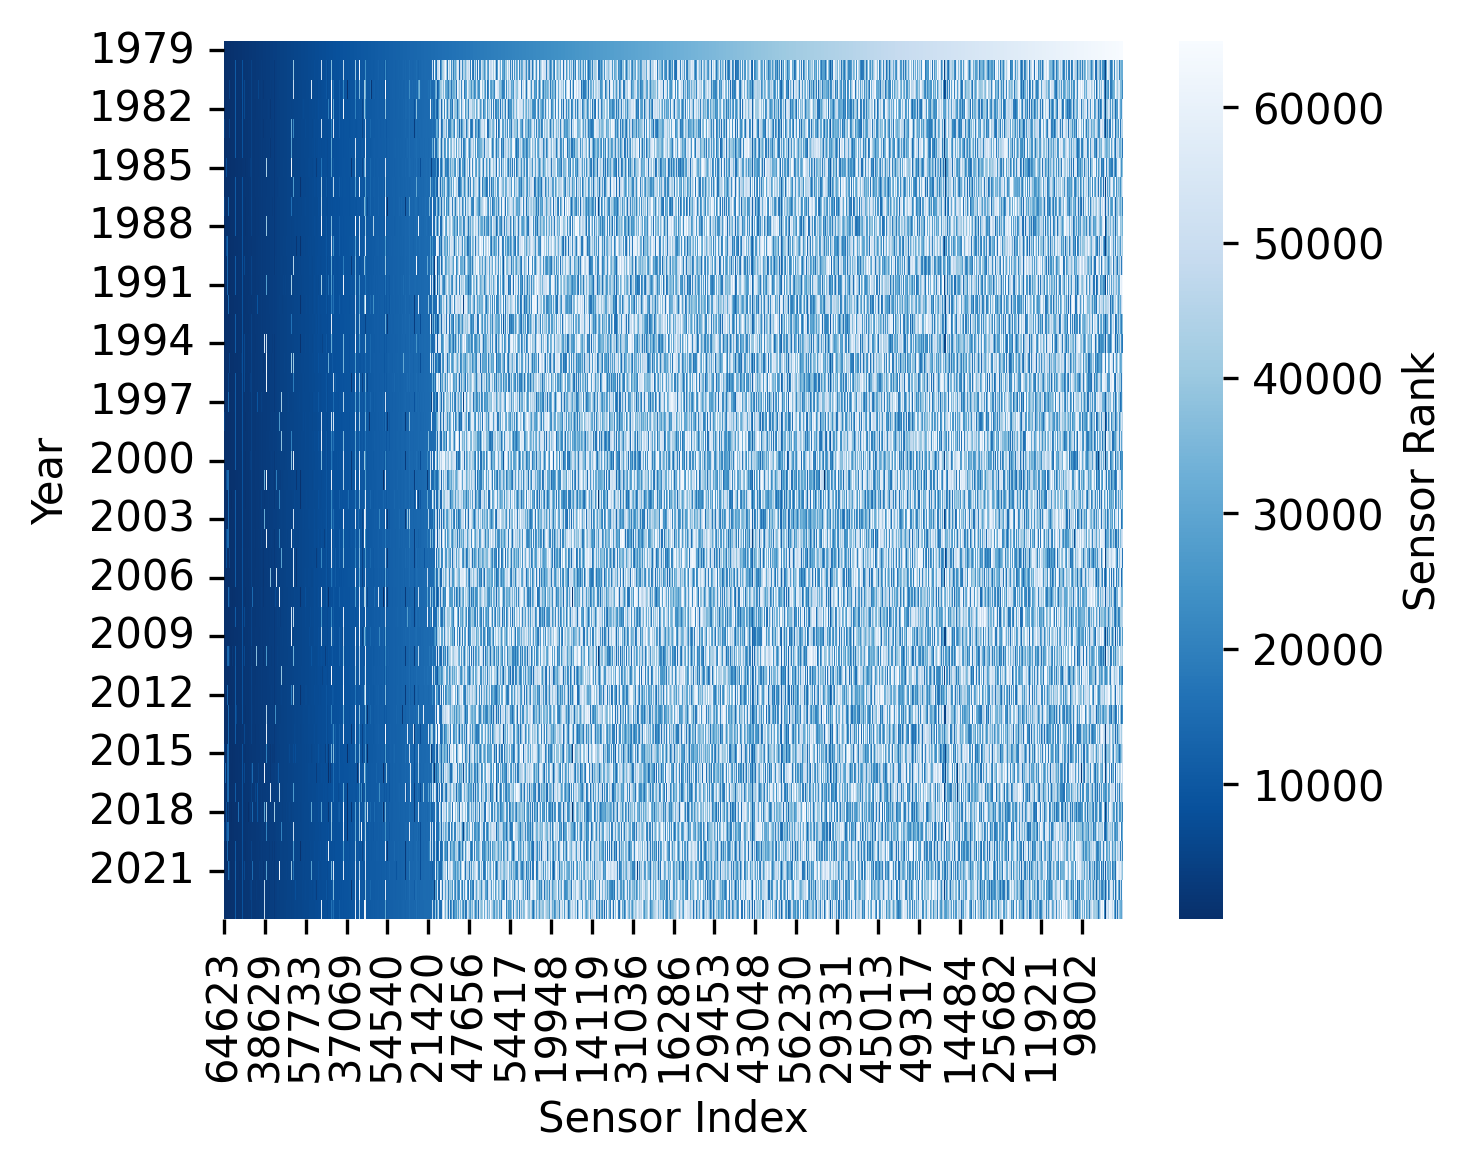

In [14]:
# Heatmap of Rankings
plt.figure(figsize=(5, 4), dpi=300)
sns.heatmap(
    rankings_df.iloc[:, :-3].T, 
    cmap='Blues_r', 
    cbar_kws={'label': 'Sensor Rank'}
)
plt.xlabel('Sensor Index')
plt.ylabel('Year')
plt.tight_layout()
plt.show()

In [16]:
median_rank_df = pd.DataFrame({
    'COMID': df_cleaned.columns[rankings_df['Median Rank'].sort_values().index[:15000]],
    'Median Rank': rankings_df['Median Rank'].sort_values().values[:15000]
})

hazard_index_df = pd.read_csv('data/nhd_variables.csv')
hazard_index_df['COMID'] = hazard_index_df['COMID'].astype(int)
median_rank_df['COMID'] = median_rank_df['COMID'].astype(int)
merged_df = hazard_index_df.merge(median_rank_df, on='COMID', how='left')

numeric_df_for_corr = merged_df.dropna().select_dtypes(include=[np.number]).drop([
    'QA_01', 'VA_01', 'QC_01', 'VC_01', 'QE_01', 'VE_01', 'QA_02', 'VA_02', 'QC_02', 'VC_02', 'QE_02', 'VE_02', 'QA_03', 'VA_03', 'QC_03', 'VC_03', 'QE_03', 'VE_03', 'QA_04', 'VA_04', 'QC_04', 'VC_04', 'QE_04', 'VE_04', 'QA_05', 'VA_05', 'QC_05', 'VC_05', 'QE_05', 'VE_05', 'QA_06', 'VA_06', 'QC_06', 'VC_06', 'QE_06', 'VE_06', 'QA_07', 'VA_07', 'QC_07', 'VC_07', 'QE_07', 'VE_07', 'QA_08', 'VA_08', 'QC_08', 'VC_08', 'QE_08', 'VE_08', 'QA_09', 'VA_09', 'QC_09', 'VC_09', 'QE_09', 'VE_09', 'QA_10', 'VA_10', 'QC_10', 'VC_10', 'QE_10', 'VE_10', 'QA_11', 'VA_11', 'QC_11', 'VC_11', 'QE_11', 'VE_11', 'QA_12', 'VA_12', 'QC_12', 'VC_12', 'QE_12', 'VE_12',
    'OBJECTID', 'COMID_1', 'FREQUENCY', 'MEAN_RFLD_AFREQ', 'COMID', 'REACHCODE', 'FromNode', 'ToNode', 'WBAREACOMI', 'FCODE', 'ONOFFNET'
], axis=1)

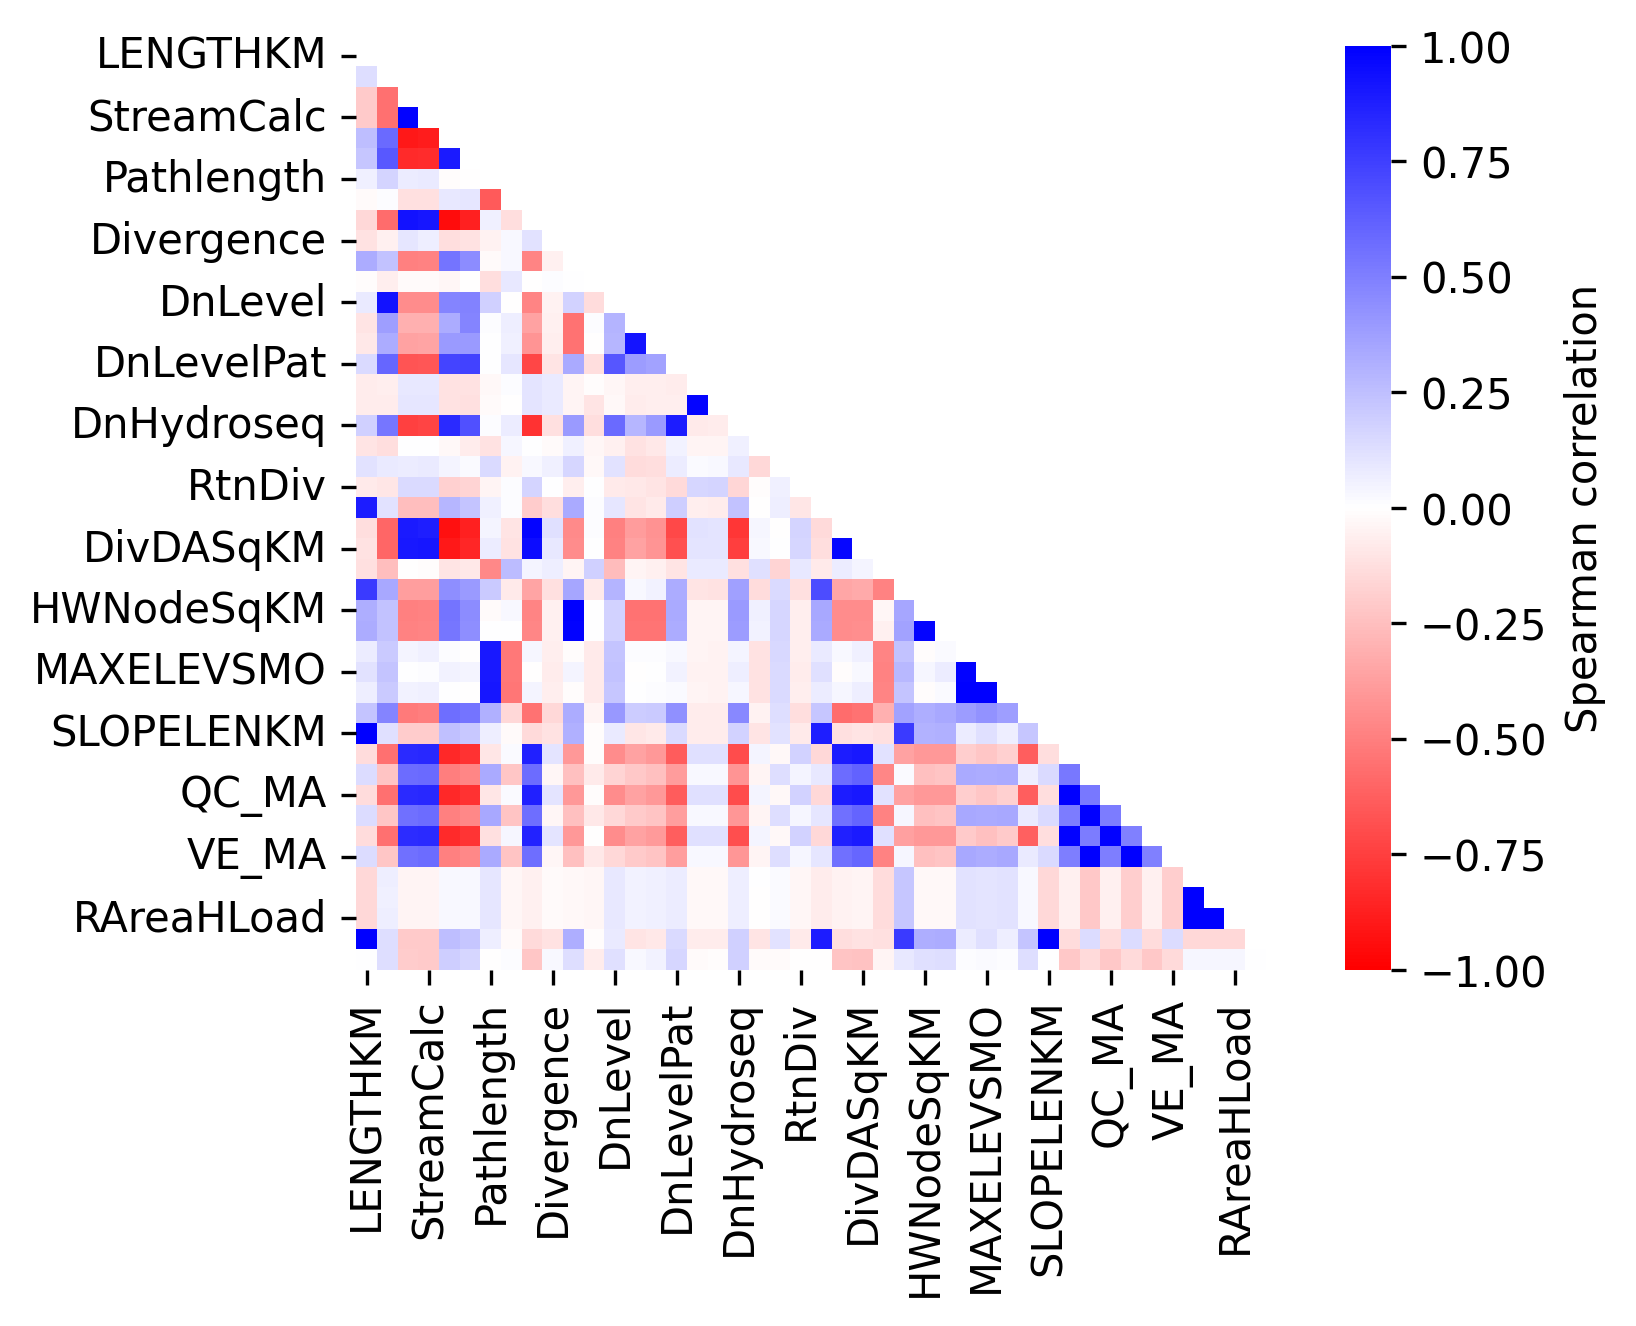

In [17]:
# Correlation Analysis
correlation_matrix = numeric_df_for_corr.corr(method='spearman')
p_values = correlation_matrix.applymap(lambda x: np.nan)

for row in correlation_matrix.columns:
    for col in correlation_matrix.columns:
        if row != col:
            rho, p_value = stats.spearmanr(numeric_df_for_corr[row], numeric_df_for_corr[col])
            p_values.loc[row, col] = p_value

plt.figure(figsize=(5, 4), dpi=300)
sns.heatmap(
    correlation_matrix, 
    mask=np.triu(np.ones_like(correlation_matrix, dtype=bool)), 
    vmin=-1, vmax=1, cmap='bwr_r', 
    cbar_kws={'label': 'Spearman correlation'}
)
plt.show()

In [18]:
median_rank_correlations = correlation_matrix['Median Rank'].sort_values(ascending=False)
median_rank_p_values = p_values['Median Rank'].loc[median_rank_correlations.index]

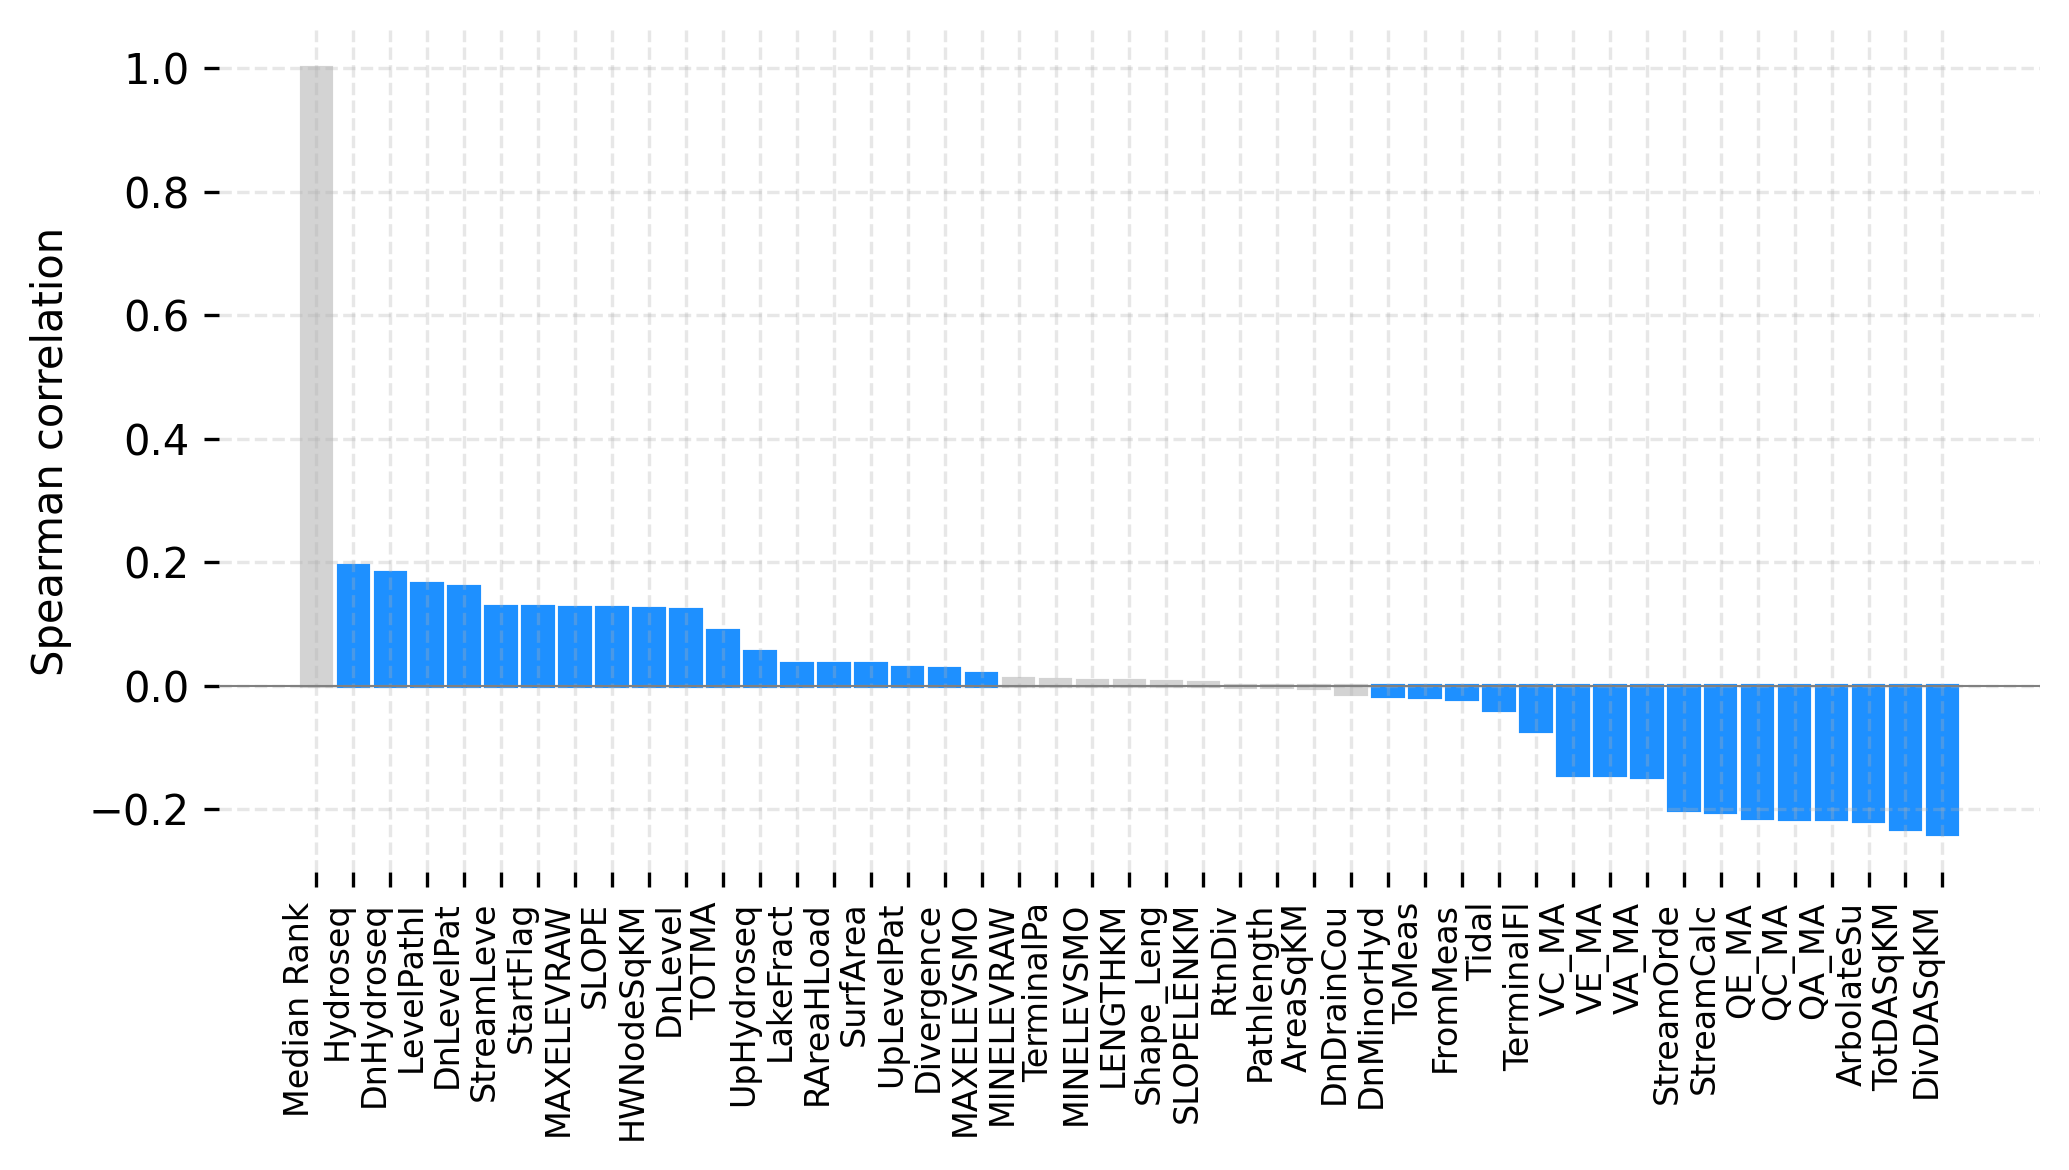

In [19]:
fig = plot_correlations_bar(
    correlations=median_rank_correlations,
    p_values=median_rank_p_values,
    significance_threshold=0.05,
    figsize=(7, 4),
    dpi=300
)